<a href="https://colab.research.google.com/github/manujsinghwal/chama-data-transformation/blob/main/chama_data_transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chama** is a relatively new, modern company, with an IOS App and Android App. To grow our company we must make a special effort in collecting all information available around the App and make it available for everyone in the company. Some information about App usage is generated by our App and our backend API. Other sources of information, like the Google Play Store, can provide very useful insights on App performance and user rating. Chama is very data-oriented and, most decisions are made based on appropriate metrics, therefore, data quality is a must and a concern of everyone involved.

# Problem Statement
Some event data come as json files and need some transformation to be structured as tables. Convert the [case.json](https://drive.google.com/file/d/1Rrse9d1600E3wM8goEpAQDA-b64D9Eml/view?usp=sharing) file to two pandas DataFrames, using Python, with the following rules:

```
Table1:
        CuratedOfferOptionsFinal
Columns:
        CurationProvider:
        OfferId:
        DealerId:
        UniqueOptionId:
        OptionId:
        IsMobileDealer:
        IsOpen:
        Eta:
        ChamaScore:
        ProductBrand:
        IsWinner:
        MinimumPrice:
        MaximumPrice:
        DynamicPrice:
        FinalPrice:
        DefeatPrimaryReason:
        DefeatReasons:
        EnqueuedDate: YYYY-MM-DD format
```

```
Table2:
        DynamicPriceRangeFinal
Columns:
        Provider:
        OfferId:
        MinGlobal:
        MinRecommended:
        MaxRecommended:
        DifferenceMinRecommendMinTheory:
        EnqueuedDate: YYYY-MM-DD format
```

# About JSON

**JSON** stands for `JavaScript Object Notation`. It's a lightweight data interchange format that is easy for humans to read and write and easy for machines to parse and generate. It's commonly used for transmitting data between a server and a web (client) application, and it's often used in APIs (Application Programming Interfaces) to send data back and forth.

JSON data is organized into key-value pairs, similar to how dictionaries work in Python. For example:

```
{
  "name": "John",
  "age": 30,
  "city": "New York"
}
```
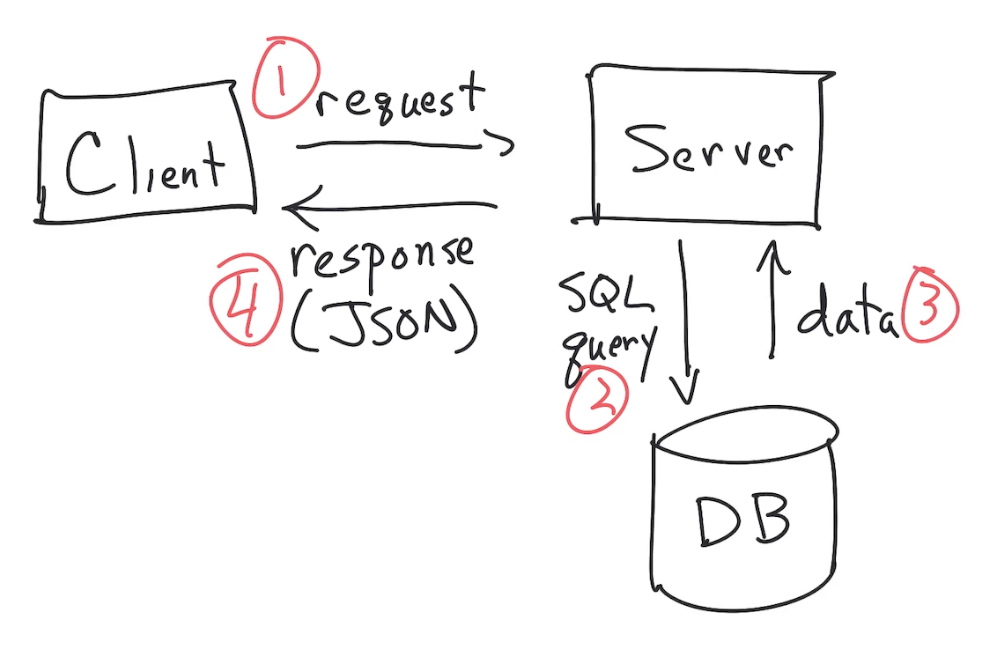

# Introduction and Data Exploration
Before going through the actual data transformation, in this section, we will spend some time getting familiar with the provided data. This will enable us to better understand the problem that the company is facing, and we could come up with a satisfactory solution.

In [ ]:
# Mounting Google drive as case.json file stored in a drive directory
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Importing other libraries for data exploration and transformation
import pandas as pd
import json
from datetime import datetime

In [ ]:
# Reading json file from Google drive directory
df = pd.read_json("gdrive/My Drive/Colab Notebooks/Dataset/case.json")

# Showing default first 5 records
df.head()

,EnqueuedTimeUtc,EventName,Payload
0,2021-09-05 08:04:08 UTC,DynamicPrice_Result,"{""provider"":""ApplyDynamicPriceRange"",""offerId""..."
1,2021-08-18 11:43:23 UTC,DynamicPrice_Result,"{""provider"":""ApplyDynamicPricePerOption"",""offe..."
2,2021-09-05 09:04:04 UTC,DynamicPrice_Result,"{""provider"":""ApplyDynamicPriceRange"",""offerId""..."
3,2021-08-25 05:02:55 UTC,CurateOffer_Result,"[{""curationProvider"":""ByPrice"",""offerId"":""149f..."
4,2021-09-05 08:03:28 UTC,DynamicPrice_Result,"{""provider"":""ApplyDynamicPriceRange"",""offerId""..."


In [ ]:
# Checking the total rows and columns available in .json file.
df.shape

(37, 3)

We have 37 rows in the DataFrame, and 3 columns:

*   `EnqueuedTimeUTC` - Timestamp of when the event occurred, in  UTC timezone.
*   `EventName` - The name of the event that occurred.
*   `Payload` - Extra info that is event-specific.

The first thing that we observe in the sample above is that different `EventName` values correspond to the tables that are requested. We will probably need to partition the DataFrame by that column.

Before partitioning the event name and going into creating the specific tables, it may be a good decision to transform the timezone now.

In [ ]:
# Checking the distinct EventName
df['EventName'].value_counts()

EventName
DynamicPrice_Result    32
CurateOffer_Result      5
Name: count, dtype: int64

# Data Transformation

In [ ]:
# Converting 'EnqueuedTimeUtc' column to datetime object
df['EnqueuedDate'] = pd.to_datetime(df['EnqueuedTimeUtc'])

# Formatting 'EnqueuedTimeUtc' column as YYYY-MM-DD format
df['EnqueuedDate'] = df['EnqueuedDate'].dt.strftime('%Y-%m-%d')

# Reframing the DataFrame
df = df[['EnqueuedDate','EnqueuedTimeUtc','EventName','Payload']]

We have two events in our data: `CurrateOffer_Result` and `DynamicPrice_Result`.

We will use the rows from the former one to create the first table, and the rows from the final one to create the second table.

**CurratedOfferOptions**

Let's first filter the curated offers from the main data set. We can see that there are only five such events (records).

In [ ]:
# Filtering the dataset for CurateOfferOptions
CuratedOfferOptions = (
    df
    .query('EventName == "CurateOffer_Result"')
    .reset_index(drop=True)
    )

CuratedOfferOptions.shape

(5, 4)

In [ ]:
# Default first five records
CuratedOfferOptions.head()

,EnqueuedDate,EnqueuedTimeUtc,EventName,Payload
0,2021-08-25,2021-08-25 05:02:55 UTC,CurateOffer_Result,"[{""curationProvider"":""ByPrice"",""offerId"":""149f..."
1,2021-08-25,2021-08-25 09:03:29 UTC,CurateOffer_Result,"[{""curationProvider"":""ByPrice"",""offerId"":""c99a..."
2,2021-08-25,2021-08-25 05:02:18 UTC,CurateOffer_Result,"[{""curationProvider"":""ByPrice"",""offerId"":""d668..."
3,2021-08-25,2021-08-25 09:02:29 UTC,CurateOffer_Result,"[{""curationProvider"":""ByPrice"",""offerId"":""0a06..."
4,2021-08-25,2021-08-25 09:03:14 UTC,CurateOffer_Result,"[{""curationProvider"":""ByPrice"",""offerId"":""135d..."


In [ ]:
# Defining a function to extract information from JSON string for CuratedOffer
def CuratedOffer(row):

    # Load JSON string
    JSONPayload = row["Payload"]
    PayloadData = json.loads(JSONPayload)

    # Extracting required fields
    OfferOptions = []

    for item in PayloadData:
        Data = {
            'CurationProvider': item.get('curationProvider', None),
            'OfferId': item.get('offerId', None),
            'DealerId': item.get('dealerId', None),
            'UniqueOptionId': item['options'][0].get('uniqueOptionId', None),
            'OptionId': item['options'][0].get('optionId', None),
            'IsMobileDealer': item['options'][0].get('isMobileDealer', None),
            'IsOpen': item['options'][0].get('isOpen', None),
            'ETA': item['options'][0].get('eta', None),
            'ChamaScore': item['options'][0].get('chamaScore', None),
            'ProductBrand': item['options'][0].get('productBrand', None),
            'IsWinner': item['options'][0].get('isWinner', None),
            'MinimumPrice': item['options'][0].get('minimumPrice', None),
            'MaximumPrice': item['options'][0].get('maximumPrice', None),
            'DynamicPrice': item['options'][0].get('dynamicPrice', None),
            'FinalPrice': item['options'][0].get('finalPrice', None),
            'DefeatPrimaryReason': item['options'][0].get('defeatPrimaryReason', None),
            'DefeatReasons': item['options'][0].get('defeatReasons', None),
            'EnqueuedDate':  row['EnqueuedDate']
        }

        OfferOptions.append(Data)

    return pd.DataFrame(OfferOptions)

In [ ]:
# Applying the function for the required fields
CuratedOfferOptionsFinal = CuratedOfferOptions.apply(CuratedOffer, axis=1)

# Concatenate all the resulting DataFrames
CuratedOfferOptionsFinal = pd.concat(
    CuratedOfferOptionsFinal.tolist(),
    ignore_index=True
    )

CuratedOfferOptionsFinal

,CurationProvider,OfferId,DealerId,UniqueOptionId,OptionId,IsMobileDealer,IsOpen,ETA,ChamaScore,ProductBrand,IsWinner,MinimumPrice,MaximumPrice,DynamicPrice,FinalPrice,DefeatPrimaryReason,DefeatReasons,EnqueuedDate
0,ByPrice,149f0e53-ff85-425f-a01a-8710f06704ea,6517,b0e296a9-0590-f0e0-8211-243a2ededb12,6517 || dd839e4c-9f84-45eb-9cb2-9069fecf70f2,True,True,1:00,8.0,ULTRAGAZ,True,90.0,180.0,91.90,91.90,None,None,2021-08-25
1,ByPrice,149f0e53-ff85-425f-a01a-8710f06704ea,9047,8d0f9262-f543-d0c8-a869-33985ae3ecda,9047 || 9047 || ULTRAGAZ,False,False,1:00,9.0,ULTRAGAZ,False,99.0,198.0,99.95,99.95,Closed,"[Closed, HigherPrice, HasDriverInOffer]",2021-08-25
2,ByPrice,149f0e53-ff85-425f-a01a-8710f06704ea,8330,151e59ac-761a-96f5-d2b9-882037a9fd28,8330 || 8330 || CONSIGAZ,False,True,0:01,8.0,CONSIGAZ,True,80.0,160.0,87.35,87.35,None,None,2021-08-25
3,ByPrice,149f0e53-ff85-425f-a01a-8710f06704ea,8835,b7a7b6d1-4dae-7392-5aaf-f3369c29db1d,8835 || 8835 || LIQUIGAS,False,False,0:01,8.0,LIQUIGAS,True,60.0,120.0,87.35,87.35,None,None,2021-08-25
4,ByPrice,c99aa9a7-ac50-4a10-be0f-ac9f5ac0f45d,6517,b0e296a9-0590-f0e0-8211-243a2ededb12,6517 || dd839e4c-9f84-45eb-9cb2-9069fecf70f2,True,True,00:12:54.9215999,8.0,ULTRAGAZ,True,90.0,180.0,91.90,91.90,None,None,2021-08-25
5,ByPrice,c99aa9a7-ac50-4a10-be0f-ac9f5ac0f45d,9047,8d0f9262-f543-d0c8-a869-33985ae3ecda,9047 || 9047 || ULTRAGAZ,False,False,1:00,9.0,ULTRAGAZ,False,99.0,198.0,99.95,99.95,Closed,"[Closed, HigherPrice, HasDriverInOffer, Higher...",2021-08-25
6,ByPrice,c99aa9a7-ac50-4a10-be0f-ac9f5ac0f45d,8330,151e59ac-761a-96f5-d2b9-882037a9fd28,8330 || 8330 || CONSIGAZ,False,True,0:01,8.0,CONSIGAZ,True,80.0,160.0,87.35,87.35,None,None,2021-08-25
7,ByPrice,c99aa9a7-ac50-4a10-be0f-ac9f5ac0f45d,8835,b7a7b6d1-4dae-7392-5aaf-f3369c29db1d,8835 || 8835 || LIQUIGAS,False,False,0:01,8.0,LIQUIGAS,True,60.0,120.0,87.35,87.35,None,None,2021-08-25
8,ByPrice,d668106a-7596-49c6-b99a-18b7a2f3963f,6517,b0e296a9-0590-f0e0-8211-243a2ededb12,6517 || dd839e4c-9f84-45eb-9cb2-9069fecf70f2,True,True,1:00,8.0,ULTRAGAZ,True,90.0,180.0,91.90,91.90,None,None,2021-08-25
9,ByPrice,d668106a-7596-49c6-b99a-18b7a2f3963f,9047,8d0f9262-f543-d0c8-a869-33985ae3ecda,9047 || 9047 || ULTRAGAZ,False,False,1:00,9.0,ULTRAGAZ,False,99.0,198.0,99.95,99.95,Closed,"[Closed, HigherPrice, HasDriverInOffer]",2021-08-25


**DynamicPriceOption**

Let's filter the dynamic price from the main data set. We can see that there are 32 such events (records).

In [ ]:
# Filtering the dataset for DynamicPriceRange
DynamicPriceRange = (
    df
    .query('EventName == "DynamicPrice_Result"')
    .reset_index(drop=True)
    )

DynamicPriceRange.shape

(32, 4)

In [ ]:
# Defining a function to extract information from JSON string for DynamicPriceRange
def DynamicPrice(row):

    # Load JSON string
    JSONPayload = row["Payload"]
    PayloadData = json.loads(JSONPayload)

    # Extracting required fields
    DynamicPriceResults = []

    if PayloadData["provider"] == "ApplyDynamicPriceRange":
        Data = {
            "Provider": PayloadData["provider"],
            "OfferId": PayloadData['offerId'],
            "MinGlobal": PayloadData["algorithmOutput"]["min_global"],
            "MinRecommended": PayloadData["algorithmOutput"]["min_recommended"],
            "MaxRecommended": PayloadData["algorithmOutput"]["max_recommended"],
            "DifferenceMinRecommendMinTheory": PayloadData["algorithmOutput"]["differenceMinRecommendMinTheory"],
            "EnqueuedDate": row['EnqueuedDate']
        }
        DynamicPriceResults.append(Data)

    return DynamicPriceResults

In [ ]:
# Applying the function for the required fields
DynamicPriceRangeFinal = DynamicPriceRange.apply(DynamicPrice, axis=1)

# Concatenate the resulting DataFrames
DynamicPriceRangeFinal = pd.concat(
    [pd.DataFrame(x) for x in DynamicPriceRangeFinal],
    ignore_index=True
    )

DynamicPriceRangeFinal

,Provider,OfferId,MinGlobal,MinRecommended,MaxRecommended,DifferenceMinRecommendMinTheory,EnqueuedDate
0,ApplyDynamicPriceRange,a6611d55-9624-4381-8cdd-323ee3689241,85.00,87.20,97.65,2.2,2021-09-05
1,ApplyDynamicPriceRange,b8c636fa-8241-47dc-ac40-bdf438a04d9c,85.00,87.20,97.65,2.2,2021-09-05
2,ApplyDynamicPriceRange,3d32f7fb-396d-4d3f-b673-dea1f7dc41b7,85.00,87.20,97.65,2.2,2021-09-05
3,ApplyDynamicPriceRange,329194f3-95a4-45ef-b3d0-2796f74ce2a0,85.00,87.20,97.65,2.2,2021-09-05
4,ApplyDynamicPriceRange,fdcfde5c-113d-4a59-9ae0-8bc31e2943d8,87.35,89.25,99.95,1.9,2021-09-05
5,ApplyDynamicPriceRange,27bbc4fa-2388-4780-b66c-92a51397d191,87.35,89.25,99.95,1.9,2021-09-05
6,ApplyDynamicPriceRange,baffc30b-7642-45fe-a2ce-da31a71732ae,85.00,87.20,97.65,2.2,2021-09-05
7,ApplyDynamicPriceRange,b5982abd-f602-47ac-b45a-bb43bf993d46,85.00,87.20,97.65,2.2,2021-09-05
8,ApplyDynamicPriceRange,f6643886-4a0f-45ae-ae32-ee95c72ee94a,87.35,89.25,99.95,1.9,2021-09-05
9,ApplyDynamicPriceRange,16a2d492-b1c3-40ec-970f-b8704d8db96f,85.00,87.20,97.65,2.2,2021-09-05


The above DataFrames are now ready to upsert into the final database tables. We can use the data pipelines to automate this task using pipeline triggers through this notebook.